In [1]:
import os 
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import sys
sys.path.append('../misc/')

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.io as sio
import time
import h5py as hp
import sympy as sym
import matplotlib.animation as animation
import mrcfile
import tifffile
import argparse

from models import *
from utils import *
from losses import *

from scipy.signal import wiener
from psf_torch import PsfGenerator3D
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, ConstantLR, OneCycleLR, MultiStepLR, ExponentialLR
from PIL import Image
from skimage.transform import rescale, resize
from torch.fft import fftn, ifftn, fftshift, ifftshift, rfftn, irfftn, rfft

dtype = torch.cuda.FloatTensor
torch.backends.cudnn.benchmark = True


gfp = custom_div_cmap(2**16-1, mincol='#000000', midcol = '#00FF00', maxcol='#FFFFFF')


parser = argparse.ArgumentParser(description="Hyperparameters - Beads")

parser.add_argument('--filepath_ref', type=str, default='../source/beads/')
parser.add_argument('--filepath', type=str, default='../source/beads/')

parser.add_argument('--net_obj_save_path_pretrained_prefix', type=str, default='../rec/')
parser.add_argument('--net_obj_save_path_pretrained_suffix', type=str, default='_skips_2468')
parser.add_argument('--net_obj_save_path_trained_prefix', type=str, default='../rec/')
parser.add_argument('--net_obj_save_path_trained_suffix', type=str, default='_skips_2468_full_trained')
parser.add_argument('--rec_save_path_prefix', type=str, default='../rec/')
parser.add_argument('--rec_save_path_suffix', type=str, default='enc_angle_3_depth_7_tvz_2em9_filters_128_skips_12')

parser.add_argument('--suffix', type=str, default='real_time')
parser.add_argument('--suffix_rec', type=str, default='rsd_reg')

parser.add_argument('--cnts', type=list, default=[100, 224, 224])
parser.add_argument('--dims', type=list, default=[100, 224, 224])
parser.add_argument('--padding', type=int, default=24)
parser.add_argument('--normalized', type=bool, default=True)
parser.add_argument('--psf_dz', type=float, default=0.2)
parser.add_argument('--psf_dy', type=float, default=0.086)
parser.add_argument('--psf_dx', type=float, default=0.086)
parser.add_argument('--n_detection', type=float, default=1.1)
parser.add_argument('--emission_wavelength', type=float, default=0.515)
parser.add_argument('--n_obj', type=float, default=1.333)

parser.add_argument('--encoding_option', type=str, default='radial')
parser.add_argument('--radial_encoding_angle', type=float, default=3,
                    help='Typically, 3 ~ 7.5. Smaller values indicates the ability to represent fine features.')
parser.add_argument('--radial_encoding_depth', type=int, default=7,
                    help='If too large, stripe artifacts. If too small, oversmoothened features. Typically, 6 or 7.') # 7, 8 (jiggling artifacts)

parser.add_argument('--nerf_num_layers', type=int, default=6)
parser.add_argument('--nerf_num_filters', type=int, default=128) 
parser.add_argument('--nerf_skips', type=list, default=[2,4,6])
parser.add_argument('--nerf_beta', type=float, default=1.0)
parser.add_argument('--nerf_max_val', type=float, default=40.0)

parser.add_argument('--pretraining', type=bool, default=True)
parser.add_argument('--pretraining_num_iter', type=int, default=400) 
parser.add_argument('--pretraining_lr', type=float, default=1e-2)
parser.add_argument('--pretraining_measurement_scalar', type=float, default=5.) # > 1
parser.add_argument('--training_num_iter', type=int, default=1000)
parser.add_argument('--training_lr_obj', type=float, default=5e-3)
parser.add_argument('--training_lr_ker', type=float, default=1e-2)
parser.add_argument('--kernel_max_val', type=float, default=1e-2)
parser.add_argument('--kernel_order_up_to', type=int, default=4) 

parser.add_argument('--ssim_weight', type=float, default=1.0)
parser.add_argument('--tv_z', type=float, default=1e-9,
                    help='larger tv_z helps for denser samples.') 
parser.add_argument('--tv_z_normalize', type=bool, default=False)
parser.add_argument('--rsd_reg_weight', type=float, default=5e-4,
                    help='Helps to retrieve aberrations correctly. Too large, skeletionize the image.')

parser.add_argument('--lr_schedule', type=str, default='cosine') 

args = parser.parse_args(args=[])


def signal_to_background_ratio_gaussian_mixture_nlm_v2(ref, tar, gf_sig = 5, 
                                                       sigma_est=60, patch_kw = None, return_imgs=False):

    im = np.max(ref, 0)
    im = denoise_nl_means(np.expand_dims(im, -1), h=0.6 * sigma_est, sigma=sigma_est,
                               fast_mode=True, **patch_kw)
    im_lp = ndimage.gaussian_filter(im, sigma=gf_sig)
    im_corr = im - im_lp

    classif = GaussianMixture(n_components=2, tol=1e-8, reg_covar=1e-6, max_iter=500, n_init=5)
    classif.fit(im_corr.reshape((im_corr.size, 1)))
    threshold = np.mean(classif.means_)

    im_b = np.copy(im)
    im_b[im_corr >= threshold] = 0

    im_aber = np.max(tar, 0)
    sbr = np.median(im_aber[im_b == 0]) / np.median(im_aber[im_b > 0])
    
    im_aber_b = np.copy(im_aber)
    im_aber_b[im_b == 0] = 0
    im_aber_s = im_aber - im_aber_b
    
    if return_imgs:
        return sbr, im_aber_b, im_aber_s, im_b, im_corr

    else:
        return sbr


fl = os.listdir(args.filepath)

for dataset_num in [0, 3]:
    # chars = 'ABC' if dataset_num > 0 else ' '
    chars = 'B' if dataset_num > 0 else ' '
    
    for dataset_char in chars:
        args.suffix = str(dataset_num) + dataset_char if dataset_num > 0 else str(dataset_num)
        
        for idx in range(len(fl)):
            if fl[idx].find(args.suffix + '-') == 0:
                folder_idx = idx
                    
        print(args.suffix)

        y_ = tifffile.imread(args.filepath + fl[folder_idx] + '/' + args.suffix + '.tif')
        y_ = y_[args.cnts[0]-args.dims[0] : args.cnts[0]+args.dims[0],
                args.cnts[1]-args.dims[1] : args.cnts[1]+args.dims[1],
                args.cnts[2]-args.dims[2] : args.cnts[2]+args.dims[2]]

        locs = str(args.cnts[0]-args.dims[0]) + '_' + str(args.cnts[0]+args.dims[0]) + '_'
        locs += str(args.cnts[1]-args.dims[1]) + '_' + str(args.cnts[1]+args.dims[1]) + '_'
        locs += str(args.cnts[2]-args.dims[2]) + '_' + str(args.cnts[2]+args.dims[2])

        y_max = np.max(y_)
        y_min = np.min(y_)

        print(0.46 * np.mean(y_) / np.sqrt(0.46 * np.mean(y_) + 1.6 ** 2))
        y_ = (y_ - y_min) / (y_max - y_min)

        print(y_.shape)

        patch_sz = 2
        patch_kw = dict(patch_size=patch_sz,      
                        patch_distance=patch_sz+1, 
                        channel_axis=-1)
        sbr = signal_to_background_ratio_gaussian_mixture_nlm_v2(y_, y_, gf_sig = 6, sigma_est = 60, patch_kw = patch_kw, return_imgs = False)
        print(sbr)


        if dataset_num > 0:
            ee = sio.loadmat(args.filepath + '/20230319-500nm-1-8-ML-678-Modesset_rms' + str(dataset_num * 2.5 / 100) + '.mat')
            wf_exp = ee['Modesset']


        y = torch.from_numpy(y_.copy()).type(dtype).cuda(0).view(y_.shape[0], y_.shape[1], y_.shape[2])

        INPUT_HEIGHT = y_.shape[1]
        INPUT_WIDTH = y_.shape[2]
        INPUT_DEPTH = y_.shape[0]

        psf = PsfGenerator3D(psf_shape=(y_.shape[0], y_.shape[1], y_.shape[2]), 
                             units=(args.psf_dz, args.psf_dy, args.psf_dx), 
                             na_detection=args.n_detection, 
                             lam_detection=args.emission_wavelength, 
                             n=args.n_obj) 

        coordinates = input_coord_2d(INPUT_WIDTH, INPUT_HEIGHT).cuda(0)
        coordinates = radial_encoding(coordinates, args.radial_encoding_angle, args.radial_encoding_depth).cuda(0) 


        net_obj = NeRF(D = args.nerf_num_layers,
                       W = args.nerf_num_filters,
                       skips = args.nerf_skips, 
                       in_channels = coordinates.shape[-1], 
                       out_channels = INPUT_DEPTH).cuda(0)

        net_obj_save_path_pretrained = args.net_obj_save_path_pretrained_prefix + 'net_obj_' + args.suffix + '_' + locs + args.net_obj_save_path_pretrained_suffix + '_' + str(args.radial_encoding_angle) + '_' + str(args.radial_encoding_depth) + '_' + str(args.nerf_num_filters) + '_' + str(np.sum(args.nerf_skips)) + '.pth'
        net_obj_save_path_trained = args.net_obj_save_path_trained_prefix + 'net_obj_' + args.suffix + '_' + locs + args.net_obj_save_path_trained_suffix + '_' + str(args.radial_encoding_angle) + '_' + str(args.radial_encoding_depth) + '_' + str(args.nerf_num_filters) + '_' + str(np.sum(args.nerf_skips)) + '.pth'


        if not os.path.exists(net_obj_save_path_pretrained) or args.pretraining:
            t_start = time.time()

            optimizer = torch.optim.Adam([{'params':net_obj.parameters(), 'lr':args.pretraining_lr}],
                                         betas=(0.9, 0.999), eps = 1e-8)
            if args.lr_schedule == 'multi_step':
                scheduler = MultiStepLR(optimizer, milestones=[1000, 1500, 2000], gamma=0.5)
            elif args.lr_schedule == 'cosine':
                scheduler = CosineAnnealingLR(optimizer, args.pretraining_num_iter, args.pretraining_lr/25)

            loss_list = np.empty(shape = (1 + args.pretraining_num_iter, ))
            loss_list[:] = np.NaN

            for step in tqdm(range(args.pretraining_num_iter)):
                out_x = net_obj(coordinates)

                if args.nerf_beta is None:
                    out_x = args.nerf_max_val * nn.Sigmoid()(out_x)
                else:
                    out_x = nn.Softplus(beta = args.nerf_beta)(out_x)

                out_x_m = out_x.view(y_.shape[1], y_.shape[2], y_.shape[0]).permute(2, 0, 1)

                loss = ssim_loss(out_x_m, args.pretraining_measurement_scalar * y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                loss_list[step] = loss.item()

            t_end = time.time()
            print('Initialization - Elapsed time: ' + str(t_end - t_start) + ' seconds.')

        else:
            net_obj.load_state_dict(torch.load(net_obj_save_path_pretrained)); print('Pre-trained model loaded.')
            net_obj.train()


        ## kernel with simple coefficients
        net_ker = optimal_kernel(max_val = args.kernel_max_val, order_up_to = args.kernel_order_up_to) # 5e-2

        optimizer = torch.optim.Adam([{'params':net_obj.parameters(), 'lr':args.training_lr_obj},  # 1e-3
                                      {'params':net_ker.parameters(), 'lr':args.training_lr_ker}], # 4e-3
                                      betas = (0.9, 0.999), eps = 1e-8)

        scheduler = CosineAnnealingLR(optimizer, args.training_num_iter, args.training_lr_ker/25)

        loss_list = np.empty(shape = (1 + args.training_num_iter, )); loss_list[:] = np.NaN
        wfe_list = np.empty(shape = (1 + args.training_num_iter, )); wfe_list[:] = np.NaN
        lr_obj_list = np.empty(shape = (1 + args.training_num_iter, )); lr_obj_list[:] = np.NaN
        lr_ker_list = np.empty(shape = (1 + args.training_num_iter, )); lr_ker_list[:] = np.NaN

        t_start = time.time()

        for step in tqdm(range(args.training_num_iter)):
            out_x = net_obj(coordinates)

            if args.nerf_beta is None:
                out_x = args.nerf_max_val * nn.Sigmoid()(out_x)
            else:
                out_x = nn.Softplus(beta = args.nerf_beta)(out_x)
                out_x = torch.minimum(torch.full_like(out_x, args.nerf_max_val), out_x) # 30.0

            out_x_m = out_x.view(y_.shape[1], y_.shape[2], y_.shape[0]).permute(2, 0, 1)

            wf = net_ker.k

            out_k_m = psf.incoherent_psf(wf, normalized = args.normalized) / y_.shape[0]
            k_vis = psf.masked_phase_array(wf)
            out_y = fft_convolve(out_x_m, out_k_m, mode='fftn')

            loss = args.ssim_weight * ssim_loss(out_y, y)

            loss += single_mode_control(wf, 1, -0.0, 0.0) # quite crucial for suppressing unwanted defocus.

            loss += args.tv_z * tv_1d(out_x_m, axis = 'z', normalize = args.tv_z_normalize)
            loss += args.rsd_reg_weight * torch.reciprocal(torch.std(out_x_m) / torch.mean(out_x_m)) # 4e-3

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if args.lr_schedule == 'cosine':
                scheduler.step()     

            elif args.lr_schedule == 'multi_step':
                if step == 500-1:
                    optimizer.param_groups[0]['lr'] = args.training_lr_obj/10

                if step == 750-1:
                    optimizer.param_groups[1]['lr'] = args.training_lr_ker/10
                    optimizer.param_groups[0]['lr'] = args.training_lr_obj/100

            loss_list[step] = loss.item()
            wfe_list[step] = torch_to_np(args.emission_wavelength * 1e3 * torch.sqrt(torch.sum(torch.square(wf)))) # wave -> nm RMS
            lr_obj_list[step] = optimizer.param_groups[0]['lr']
            lr_ker_list[step] = optimizer.param_groups[1]['lr']


        t_end = time.time()
        print('Training - Elapsed time: ' + str(t_end - t_start) + ' seconds.')


        y = torch_to_np(y)
        out_x_m = torch_to_np(out_x_m)
        out_k_m = torch_to_np(out_k_m)
        out_y = torch_to_np(out_y)
        wf = torch_to_np(wf)

        hf = hp.File(args.rec_save_path_prefix + 'rec_' + args.suffix + '_' + locs + '_normalized_' + str(args.normalized) + '_' + args.suffix_rec + '_num_iter_' + str(args.training_num_iter) + '_' + args.rec_save_path_suffix + '_' + str(args.nerf_num_filters) + '_' + str(np.sum(args.nerf_skips)) + '.h5', 'w')
        hf.create_dataset('out_x_m', data=out_x_m[:, 
                                                  args.padding:2*args.dims[1]+args.padding, 
                                                  args.padding:2*args.dims[2]+args.padding])
        hf.create_dataset('out_k_m', data=out_k_m)
        hf.create_dataset('out_y', data=out_y)
        hf.create_dataset('wf', data=wf)
        hf.create_dataset('loss_list', data=loss_list)
        hf.create_dataset('y', data=y)
        hf.create_dataset('y_min', data=y_min)
        hf.create_dataset('y_max', data=y_max)
        hf.close()

        f = open(args.rec_save_path_prefix + 'rec_' + args.suffix + '_' + locs + '_normalized_' + str(args.normalized) + '_' + args.suffix_rec + '_num_iter_' + str(args.training_num_iter) + '_' + args.rec_save_path_suffix + '_' + str(args.nerf_num_filters) + '_' + str(np.sum(args.nerf_skips)) + '.txt', 'w')
        f.write(str(vars(args)))
        f.close()

        if dataset_num == 0:
            wf_est = estimated_to_given_conversion_ml_to_dmd(wf, order_up_to = args.kernel_order_up_to)
            wf_ref = wf_est

        else:
            wf_est = estimated_to_given_conversion_ml_to_dmd(wf, order_up_to = args.kernel_order_up_to)
            wf = wf_est
                
        # Post-processing
        th = out_x_m.mean() + 1.5 * out_x_m.std()
        out_x_m = np.maximum(out_x_m, th)


wf_dm = np.zeros((12, ))
wf_dm[2] = wf_exp[1, 0]
wf_dm[3] = wf_exp[1, 1]
wf_dm[4] = wf_exp[1, 2]

0
82.98217572898245
(100, 448, 448)
1.435704697986577


C:\Users\conta\anaconda3\envs\pyt2\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:11<00:00, 33.57it/s]


Initialization - Elapsed time: 11.924802541732788 seconds.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 14.08it/s]


Training - Elapsed time: 71.02275276184082 seconds.
3B
77.76818603376032
(100, 448, 448)
1.37601246105919


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:11<00:00, 33.63it/s]


Initialization - Elapsed time: 11.894882440567017 seconds.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:12<00:00, 13.73it/s]


Training - Elapsed time: 72.82450890541077 seconds.


DWS (wave) - Mode 6, 7, 8:
[-0.099 -0.083 -0.068]
CoCoA (wave) - Mode 6, 7, 8:
[-0.097 -0.074 -0.073]
RMS wavefront error (wave RMS): 0.023


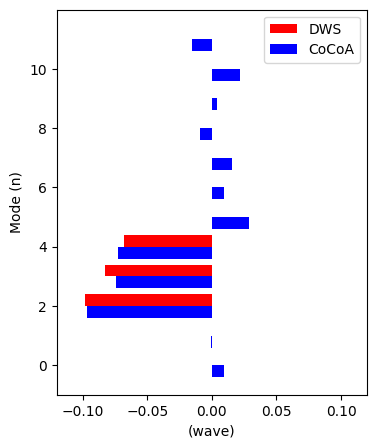

In [2]:
print('DWS (wave) - Mode 6, 7, 8:')
print(np.round(wf_dm[2:5] / args.emission_wavelength * 2, 3))

print('CoCoA (wave) - Mode 6, 7, 8:')
print(np.round((wf - wf_ref)[2:5] / args.emission_wavelength * 2, 3))

print('RMS wavefront error (wave RMS): ' + str(np.round(np.sqrt(np.sum(np.square(wf_dm - (wf - wf_ref)) / args.emission_wavelength * 2)), 3)))


plt.figure(figsize = (4, 5))
plt.barh(np.arange(0, 12)+0.2, wf_dm / args.emission_wavelength * 2, height=0.4, label = 'DWS', color = 'r')
plt.barh(np.arange(0, 12)-0.2, (wf - wf_ref) / args.emission_wavelength * 2, height=0.4, label = 'CoCoA', color = 'b')
plt.legend()
plt.xlim(-0.12, 0.12)
plt.xlabel('(wave)')
plt.ylabel('Mode (n)')
plt.show()

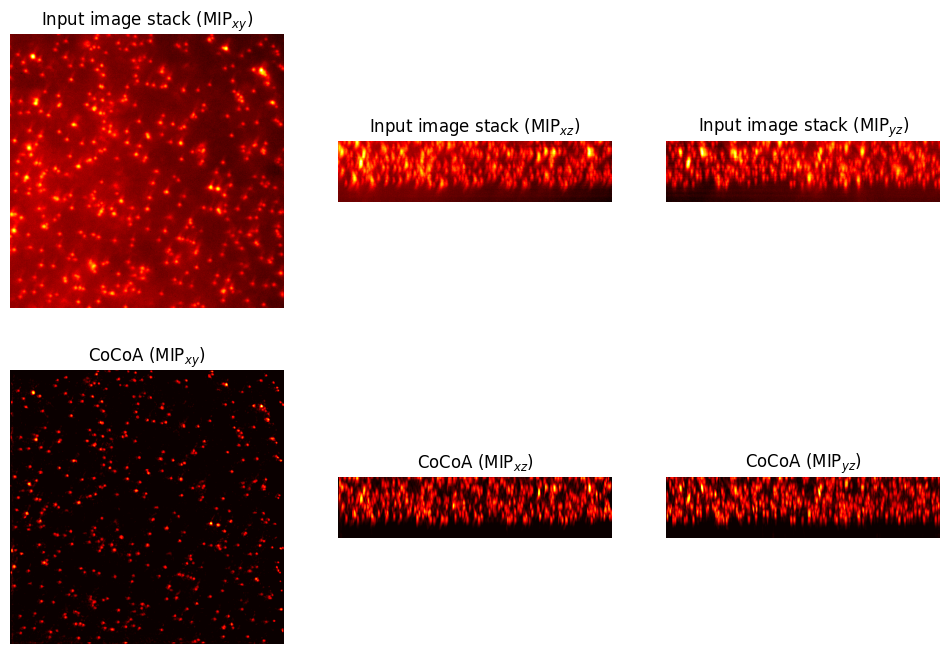

In [3]:
# Visualization: MIP along z, y, x-axes. Comparing the input image stack and the reconstructed structure.
plt.figure(figsize = (12, 8))
plt.subplot(2,3,1); plt.imshow(y_.max(0), cmap = 'hot'); plt.title('Input image stack (MIP$_{xy}$)'); plt.axis('off')
plt.subplot(2,3,4); plt.imshow(out_x_m.max(0), cmap = 'hot'); plt.title('CoCoA (MIP$_{xy}$)'); plt.axis('off')
plt.subplot(2,3,2); plt.imshow(y_.max(1), cmap = 'hot'); plt.title('Input image stack (MIP$_{xz}$)'); plt.axis('off')
plt.subplot(2,3,5); plt.imshow(out_x_m.max(1), cmap = 'hot'); plt.title('CoCoA (MIP$_{xz}$)'); plt.axis('off')
plt.subplot(2,3,3); plt.imshow(y_.max(2), cmap = 'hot'); plt.title('Input image stack (MIP$_{yz}$)'); plt.axis('off')
plt.subplot(2,3,6); plt.imshow(out_x_m.max(2), cmap = 'hot'); plt.title('CoCoA (MIP$_{yz}$)'); plt.axis('off')
plt.show()

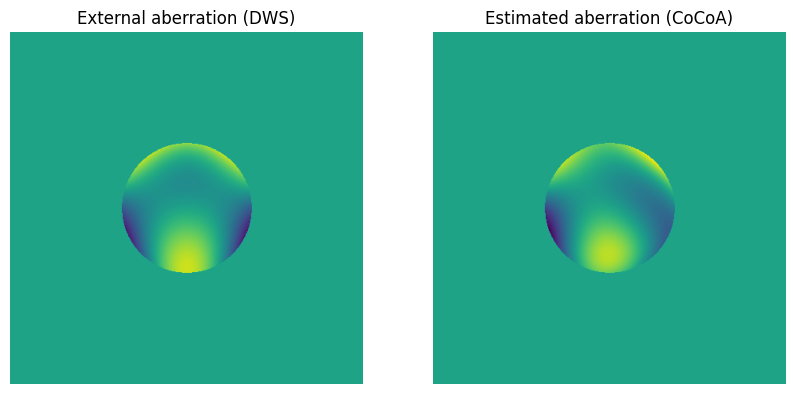

In [4]:
# Visualization: Estimated aberration map by CoCoA.
k_vis_given = psf.masked_phase_array(wf_dm * 2 / 0.515).detach().cpu().numpy()
k_vis_est = psf.masked_phase_array((wf - wf_ref) / 0.515 * 2).detach().cpu().numpy()

vmin = np.minimum(np.nanmin(k_vis_given), np.nanmin(k_vis_est))
vmax = np.maximum(np.nanmax(k_vis_given), np.nanmax(k_vis_est))

plt.figure(figsize = (10, 5))
plt.subplot(1,2,1); plt.imshow(np.fft.fftshift(k_vis_given), vmin = vmin, vmax = vmax); plt.axis('off'); plt.title('External aberration (DWS)')
plt.subplot(1,2,2); plt.imshow(np.fft.fftshift(k_vis_est), vmin = vmin, vmax = vmax); plt.axis('off'); plt.title('Estimated aberration (CoCoA)')
plt.show()